Σε αυτήν την εργασία, τα αποτελέσματα θα διαφέρουν κάθε φορά που εκτελούμε τον κώδικα, λόγω της τυχαιότητας της εκτέλεσης της εντολής node2vec, αλλά σε κάθε περίπτωση είναι σχεδόν πανομοιότυπα.

In [ ]:
!pip install node2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import community
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
from node2vec import Node2Vec
from sklearn.cluster import KMeans
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import itertools
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Create the graph we will need
G = nx.read_gml("/content/polbooks.gml", label='id')

In [ ]:
nx.is_connected(nx.Graph(G))

True

Βλέπω ότι ο γράφος είναι συνδεδεμένος, οπότε δεν θα χρειαστεί να πάρω την μεγαλύτερη συνεκτική συνιστώσα.

H εργασία ακολουθεί την ίδια προεπεξεργασία αρχείου, όπως και αυτήν που πραγματοποίησα στην 2η εργασία που μας είχε ανατεθεί.

Βρίσκουμε αρχικά τα ground truth communities που υπάρχουν, και κάνουμε plot τον γράφο για να έχουμε μία γενική ιδέα για την τοπολογία του δικτύου.

In [ ]:
# Get the label values for each node
node_labels = nx.get_node_attributes(G, "value")

In [ ]:
# I want to find my ground truth communities as lists, so first im creating an new dict having as keys the values of my node_labels and 
# as values, the list of the nodes that had the same label
new_dict = {}
for value in set(node_labels.values()):
    new_dict[value] = []
for key, value in node_labels.items():
    new_dict[value].append(key)

# And now creating the list of our communities 
communities_ground_truth = [[value for value in values] for values in new_dict.values()]

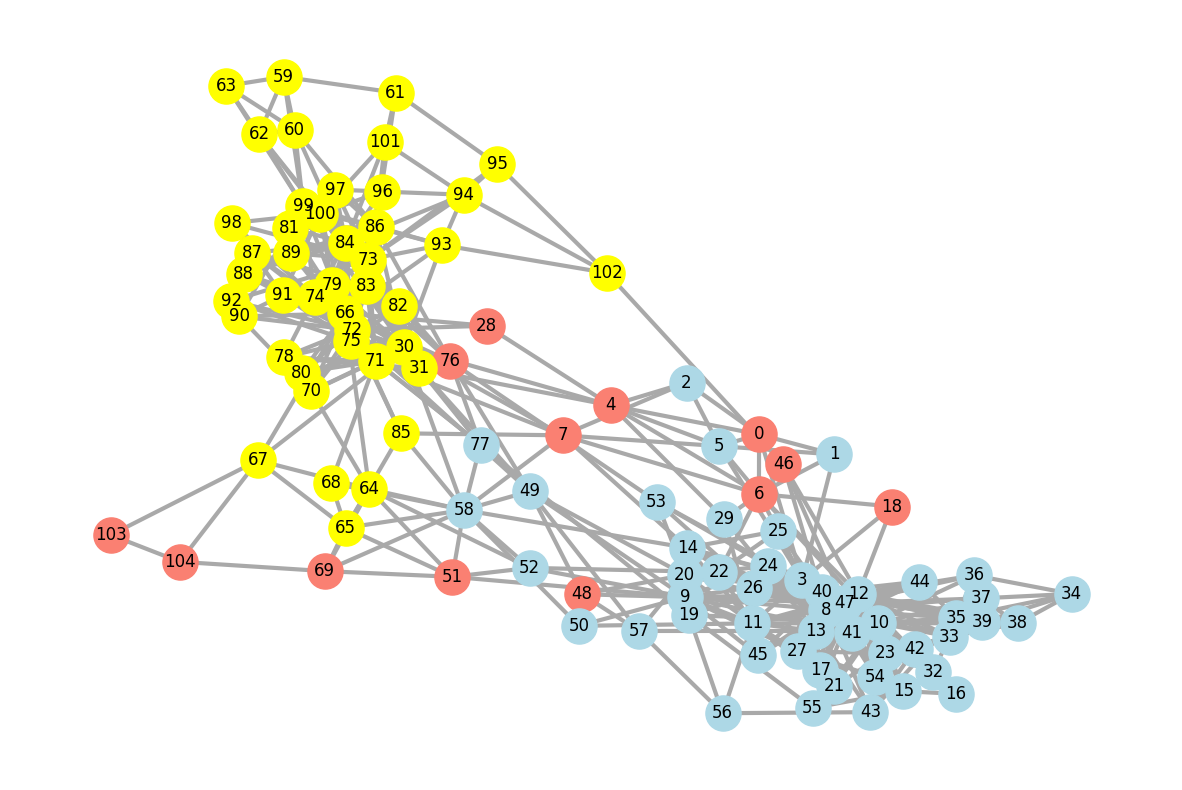

In [ ]:
# We have 3 ground truth communities so we are using three colors in order to plot the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(15,10))
colors = ['salmon', 'lightblue','yellow']
nx.draw_networkx_edges(G, pos=pos, width=3, edge_color='darkgray')
for community, color in zip(communities_ground_truth, colors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=community, node_color=color, node_size=640)
nx.draw_networkx_labels(G, pos=pos)
_ = plt.axis('off')

In [ ]:
# Creating again the label_dict to store the label of each cluster
label_dict={}
for i, j in enumerate(communities_ground_truth):
  for value in j:
    label_dict[value] = i

# And now appending the labels in our previous dataframe 
# We will store all of our information in a dataframe so that we can manipulate it easier
df = pd.DataFrame.from_dict(label_dict, orient='index',columns=['ground_truth_labels'])
df.sort_index(inplace=True)


Εδώ πέρα σχηματίζουμε τα node embeddings και τις τις 3 διαφορετικές περιπτώσεις
Ο κώδικας θα είναι ο ίδιος για κάθε περίπτωση node embedding και το μόνο που θα αλλάζει είναι η ονομασία των μεταβλητών για να ξεχωρίζουμε κάθε φορά την περίπτωση στην οποία βρισκόμαστε.

# Node2Vec q=2, p=1 

In [ ]:
# Compute Node Embeddings 
first_node2vec = Node2Vec(G, dimensions=64, p=1, q=2)

# Fitting the model
first_model = first_node2vec.fit()

# Creating the embeddings variable 
embeddings_1 = first_model.wv

# Get the node names (keys)
nodes = first_model.wv.index_to_key

# Create a dictionary to store the node embeddings
node_embeddings = {}

# Adding values to the dictionary
for node in nodes:
    embedding = first_model.wv[node]
    node_embeddings[node] = embedding

# Create a DataFrame from the dictionary
df_embed_1 = pd.DataFrame.from_dict(node_embeddings, orient='index')

# Rename the columns with names of their dimensions
df_embed_1.columns = [f'dimension_{i}' for i in range(df_embed_1.shape[1])]

df_embed_1.index.name = 'node_index'

# Convert the index from string to numeric
df_embed_1.index = pd.to_numeric(df_embed_1.index)

# Sorting the values in order for our dataframe to be easier readable
df_embed_1.sort_index(inplace=True)


Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 31.93it/s]


In [ ]:
df_embed_1

,dimension_0,dimension_1,dimension_2,dimension_3,dimension_4,dimension_5,dimension_6,dimension_7,dimension_8,dimension_9,...,dimension_54,dimension_55,dimension_56,dimension_57,dimension_58,dimension_59,dimension_60,dimension_61,dimension_62,dimension_63
node_index,,,,,,,,,,,,,,,,,,,,,
0,0.380782,0.024497,0.223754,0.040679,0.203834,0.138521,0.588733,-0.123821,-0.002019,-0.049121,...,-0.058488,0.061970,0.136987,-0.229143,0.200530,0.073817,0.150767,-0.447812,-0.071807,-0.424048
1,0.507594,0.182905,0.245334,-0.007272,0.287507,0.065491,0.550311,-0.111406,-0.106124,0.008770,...,0.031278,0.156399,0.259018,-0.285797,0.234946,0.012782,0.056053,-0.277065,0.015622,-0.354627
2,0.537692,-0.226548,0.359463,0.030313,0.256596,0.009163,0.573341,0.070331,-0.141248,-0.057821,...,-0.071552,0.171043,0.075123,-0.279270,0.149999,0.226983,-0.030184,-0.250959,-0.045564,-0.393749
3,0.315665,0.128133,0.066663,-0.035049,-0.023511,-0.213628,0.319766,-0.267426,-0.302682,0.205724,...,0.089713,0.264198,0.573541,-0.299346,0.130494,0.041288,0.060944,-0.118762,0.240348,-0.032609
4,0.240428,-0.161633,0.158378,0.108705,0.317314,0.122057,0.463975,0.047467,0.184707,-0.248591,...,-0.042968,0.143896,0.028739,-0.012058,0.049006,-0.011567,0.263418,-0.396493,0.145470,-0.506408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.150373,-0.181801,0.594582,0.302906,-0.047934,-0.563759,0.273891,0.028407,-0.292872,-0.154429,...,-0.145316,-0.041767,-0.248580,0.097835,0.295400,0.155287,0.452981,-0.524208,-0.345153,0.144060
101,-0.006193,0.006308,0.621371,0.306699,0.138523,-0.532451,0.184348,-0.088650,-0.487445,-0.082711,...,-0.087154,-0.097259,-0.223772,-0.021931,-0.028750,0.396297,0.446210,-0.435680,-0.507473,0.211379
102,0.221772,-0.197832,0.108362,0.359844,0.291518,-0.029963,-0.121324,0.156095,-0.232820,-0.145173,...,0.208738,-0.058067,0.282743,0.176784,-0.352645,0.139565,0.094619,-0.704020,-0.371400,0.141819


# Node2Vec q = 0.5, p = 1

In [ ]:
# Compute Node Embeddings 
second_node2vec = Node2Vec(G, dimensions=64, p=1, q=2)

# Fitting the model
second_model = second_node2vec.fit()

# Creating the embeddings variable 
embeddings_2 = second_model.wv

# Get the node names (keys)
nodes_2 = second_model.wv.index_to_key

# Create a dictionary to store the node embeddings
node_embeddings_2 = {}

# Assing values to the dictionary
for node in nodes_2:
    embedding = second_model.wv[node]
    node_embeddings_2[node] = embedding

# Create a DataFrame from the dictionary
df_embed_2 = pd.DataFrame.from_dict(node_embeddings_2, orient='index')

# Rename the columns with names of their dimensions
df_embed_2.columns = [f'dimension_{i}' for i in range(df_embed_2.shape[1])]

df_embed_2.index.name = 'node_index'

# Convert the index from string to numeric
df_embed_2.index = pd.to_numeric(df_embed_2.index)

df_embed_2.sort_index(inplace=True)

Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 32.91it/s]


# Node2Vec q = 1, p = 1

In [ ]:
## Compute Node Embeddings 
third_node2vec = Node2Vec(G, dimensions=64, p=1, q=2)

# Fitting the model
third_model = third_node2vec.fit()

# Creating the embeddings variable 
embeddings_3 = third_model.wv

# Get the node names (keys)
nodes_3 = third_model.wv.index_to_key

# Create a dictionary to store the node embeddings
node_embeddings_3 = {}

# Assing values to the dictionary
for node in nodes_3:
    embedding = third_model.wv[node]
    node_embeddings_3[node] = embedding

# Create a DataFrame from the dictionary
df_embed_3 = pd.DataFrame.from_dict(node_embeddings_3, orient='index')

# Rename the columns with names of their dimensions
df_embed_3.columns = [f'dimension_{i}' for i in range(df_embed_3.shape[1])]

df_embed_3.index.name = 'node_index'

# Convert the index from string to numeric
df_embed_3.index = pd.to_numeric(df_embed_3.index)

df_embed_3.sort_index(inplace=True)

Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 19.05it/s]


# Link Prediction

Αρχικά αποθηκεύουμε σε μία λίστα τις υπάρχοντες ακμές στην μεταβλητή positives και βρίσκουμε όλες τις ακμές που δεν υπάρχουν στην μεταβλητή negatives.
Ο αριθμός των ακμών μεταξύ κόμβων όμως που δεν υπάρχουν είναι πολύ μεγαλύτερος συγκριτικά με τον αριθμό των κόμβων που υπάρχουν, οπότε πρέπει να κρατήσουμε μόνο τόσους κόμβους όσοι είναι και ο αριθμός των positives.

Στην συνέχεια δημιουργούμε τα διανύσματα samples_embeddings(το οποίο παίζει τον ρόλο των εξαρτημένων μεταβλητών), στο οποίο αποθηκεύονται τα ζευγάρια embeddings των κόμβων που έχουμε αποθηκέυσει στην μεταβλητή samples, και την μεταβλητή labels(που παίζει τον ρόλο της μεταβλητής που θέλουμε να προβλέψουμε), που μας λέει ότι το κάθε ζευγάρι κόμβων ενώνεται με ακμή αν έχει την τιμή 1 , και δεν ενώνεται αν έχει την τιμή 0.

In [ ]:
# Get all existing edges (positive samples)
positives = list(G.edges())
# Get all possible node pairs (excluding existing edges)
nodes = list(G.nodes())
all_pairs = list(itertools.combinations(nodes, 2))
existing_pairs = set(positives)
negatives = list(set(all_pairs) - existing_pairs)

# Randomly sample negative samples
num_negatives = len(positives)  # Adjust the number of negative samples if needed
random.seed(0)
random.shuffle(negatives)
negatives = negatives[:num_negatives]

# Create new node embeddings that have intger values as keys
new_node_embeddings_1={}
for key, value in node_embeddings.items():
    new_key = int(key) 
    new_node_embeddings_1[new_key] = value

# Combine positive and negative samples
samples = np.vstack((positives, negatives))
labels = np.concatenate((np.ones(len(positives)), np.zeros(len(negatives))))

# Initialize an empty list to store the node embeddings for each sample
sample_embeddings_1 = []

# Retrieve embeddings for each node pair in the samples
for sample in samples:
    node1, node2 = sample
    embedding1 = new_node_embeddings_1[node1]
    embedding2 = new_node_embeddings_1[node2]
    sample_embeddings_1.append([embedding1, embedding2])

# Convert the sample_embeddings list to a NumPy array
sample_embeddings_1 = np.array(sample_embeddings_1)

Έτσι βρισκόμαστε σε θέση να εκπαιδέυσουμε το μοντέλο της λογιστικής παλινδρόμησης, αφού πρώτα χωρίσουμε το σύνολο δεδομένων μας σε train και test samples, και στην συνέχεια να εξετάσουμε τα αποτελέσματα μας. 

In [ ]:
# Reshape the embeddings to 2D
num_samples, embedding_dim,_  = sample_embeddings_1.shape
reshaped_embeddings_1 = sample_embeddings_1.reshape(num_samples, -1)
# Split the data train - test sets
X_train, X_test, y_train, y_test = train_test_split(reshaped_embeddings_1, labels, test_size=0.2, random_state=0)

# Train the logistic regression classifier
classifier_1 = LogisticRegression()
classifier_1.fit(X_train, y_train)

# Predict on the test set
y_pred_1 = classifier_1.predict(X_test)

# Calculate metrics
accuracy_1 = accuracy_score(y_test, y_pred_1)
precision_1 = precision_score(y_test, y_pred_1)
recall_1 = recall_score(y_test, y_pred_1)
print(accuracy_1)
print(precision_1)
print(recall_1)

0.807909604519774
0.7777777777777778
0.8651685393258427


Δουλεύουμε όμοια και για τις άλλες δύο περιπτώσεις: 

In [ ]:
# Create new node embeddings that have intger values as keys
new_node_embeddings_2={}
for key, value in node_embeddings_2.items():
    new_key = int(key) 
    new_node_embeddings_2[new_key] = value

# Combine positive and negative samples
samples = np.vstack((positives, negatives))
labels = np.concatenate((np.ones(len(positives)), np.zeros(len(negatives))))

# Initialize an empty list to store the node embeddings for each sample
sample_embeddings_2 = []

# Retrieve embeddings for each node pair in the samples
for sample in samples:
    node1, node2 = sample
    embedding1 = new_node_embeddings_2[node1]
    embedding2 = new_node_embeddings_2[node2]
    sample_embeddings_2.append([embedding1, embedding2])

# Convert the sample_embeddings list to a NumPy array
sample_embeddings_2 = np.array(sample_embeddings_2)

# Reshape the embeddings to 2D
num_samples, embedding_dim,_  = sample_embeddings_2.shape
reshaped_embeddings_2 = sample_embeddings_2.reshape(num_samples, -1)
# Split the data train - test sets
X_train, X_test, y_train, y_test = train_test_split(reshaped_embeddings_2, labels, test_size=0.2, random_state=0)

# Train the logistic regression classifier
classifier_2 = LogisticRegression()
classifier_2.fit(X_train, y_train)

# Predict on the test set
y_pred_2 = classifier_2.predict(X_test)

# Calculate metrics
accuracy_2 = accuracy_score(y_test, y_pred_2)
precision_2 = precision_score(y_test, y_pred_2)
recall_2 = recall_score(y_test, y_pred_2)
print(accuracy_2)
print(precision_2)
print(recall_2)

0.7853107344632768
0.7428571428571429
0.8764044943820225


In [ ]:
# Create new node embeddings that have intger values as keys
new_node_embeddings_3={}
for key, value in node_embeddings_3.items():
    new_key = int(key) 
    new_node_embeddings_3[new_key] = value

# Combine positive and negative samples
samples = np.vstack((positives, negatives))
labels = np.concatenate((np.ones(len(positives)), np.zeros(len(negatives))))

# Initialize an empty list to store the node embeddings for each sample
sample_embeddings_3 = []

# Retrieve embeddings for each node pair in the samples
for sample in samples:
    node1, node2 = sample
    embedding1 = new_node_embeddings_3[node1]
    embedding2 = new_node_embeddings_3[node2]
    sample_embeddings_3.append([embedding1, embedding2])

# Convert the sample_embeddings list to a NumPy array
sample_embeddings_3 = np.array(sample_embeddings_3)

# Reshape the embeddings to 2D
num_samples, embedding_dim,_  = sample_embeddings_3.shape
reshaped_embeddings_3 = sample_embeddings_3.reshape(num_samples, -1)
# Split the data train - test sets
X_train, X_test, y_train, y_test = train_test_split(reshaped_embeddings_3, labels, test_size=0.2, random_state=0)

# Train the logistic regression classifier
classifier_3 = LogisticRegression()
classifier_3.fit(X_train, y_train)

# Predict on the test set
y_pred_3 = classifier_3.predict(X_test)

# Calculate metrics
accuracy_3 = accuracy_score(y_test, y_pred_3)
precision_3 = precision_score(y_test, y_pred_3)
recall_3 = recall_score(y_test, y_pred_3)
print(accuracy_3)
print(precision_3)
print(recall_3)

0.8305084745762712
0.7920792079207921
0.898876404494382


Παρακάτω παρουσιάζονται συνοπτικά τα αποτελέσματα για το link prediction χρησιμοποιώντας το μοντέλο της λογιστικής παλινδρόμησης.  

\begin{array}{llll}
Case used for Link prediction   & Accuracy & Precision & Recall\\
Node2Vec (q = 2, p = 1) & 0.808       & 0.778       & 865   \\
Node2Vec (q = 0.5, p = 1)      & 0.785       & 0.743      & 0.876  \\
Node2Vec (q = 1, p = 1) & 0.831       & 0.792       & 0.899 
\end{array}

Μπορούμε πολύ εύκολα να καταλάβουμε ότι η χρήση των Embeddings μπορεί να βοηθήσει πάρα πολύ στο link prediction. Και οι τρεις περιπτώσεις βλέπουμε ότι παράγουν το ίδιο καλά αποτελέσματα. 

# K - Means

Από εδώ ξεκινάει το κομμάτι του κώδικα που σχετίζεται με το δεύτερο κομμάτι της εργασίας, και πιο συγκεκριμένα, αυτό που σχετίζεται με τον k-means. 

Θα δουλέυουμε κάθε φορά παράλληλα και για τις τρεις περιπτώσεις. Ο κώδικας πάλι θα είναι ο ίδιος για κάθε περίπτωση, μόνο που θα αλλάζουν τα ονόματα των μεταβλητών.

Αρχικά, χρησιμοποιώντας τον αλγόριθμο και για τις τρεις περιπτώσεις, σχηματίζονται labels για τα nodes τα οποία αποθηκεύουμε σε ένα dataframe για να μας βοηθήσει αργότερα.

In [ ]:
# K means for our first model
# Using k means fit method
kmeans_1 = KMeans(n_clusters=3, random_state=0).fit(df_embed_1)

# Get labels from clustering
cluster_labels_1 = kmeans_1.predict(df_embed_1)

# And now creating a dictionary containing the labels of each node using kmeans
label_dict_1 = {index: element for index, element in enumerate(cluster_labels_1)}

# Storing it into our dataframe
df['Clustering_1'] = None

for key, value in label_dict_1.items():
    df.loc[key, 'Clustering_1'] = value

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# K means for our second model
# Using k means fit method
kmeans_2 = KMeans(n_clusters=3, random_state=0).fit(df_embed_2)

# Get labels from clustering
cluster_labels_2 = kmeans_1.predict(df_embed_2)

# And now creating a dictionary containing the labels of each node using kmeans
label_dict_2 = {index: element for index, element in enumerate(cluster_labels_2)}

# Storing it into our dataframe
df['Clustering_2'] = None

for key, value in label_dict_2.items():
    df.loc[key, 'Clustering_2'] = value

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# K means for our third model
# Using k means fit method
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(df_embed_3)

# Get labels from clustering
cluster_labels_3 = kmeans_3.labels_

# And now creating a dictionary containing the labels of each node using kmeans
label_dict_3 = {index: element for index, element in enumerate(cluster_labels_3)}

# Storing it into our dataframe
df['Clustering_3'] = None

for key, value in label_dict_3.items():
    df.loc[key, 'Clustering_3'] = value

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
df

,ground_truth_labels,Clustering_1,Clustering_2,Clustering_3
0,0,1,2,0
1,1,1,2,0
2,1,1,2,0
3,1,1,2,0
4,0,1,1,0
...,...,...,...,...
100,2,2,1,1
101,2,2,1,1
102,2,2,2,1
103,0,0,1,2


Αφού έχει σχηματιστεί το dataframe, δημιουργούμε τις λίστες οι οποίες περιλαμβάνουν τα communities που βρέθηκαν χρησιμοποιώντας τον k-means.

In [ ]:
# Finding communities vectors using the dictionaries in each case

# First k-means
communities_1 = [[],[],[]]

for key, value in label_dict_1.items():
    if value == 0:
        communities_1[0].append(key)
    elif value == 1:
        communities_1[1].append(key)
    elif value == 2:
        communities_1[2].append(key)

# Second k-means
communities_2 = [[],[],[]]

for key, value in label_dict_2.items():
    if value == 0:
        communities_2[0].append(key)
    elif value == 1:
        communities_2[1].append(key)
    elif value == 2:
        communities_2[2].append(key)

# Third k-means
communities_3 = [[],[],[]]

for key, value in label_dict_3.items():
    if value == 0:
        communities_3[0].append(key)
    elif value == 1:
        communities_3[1].append(key)
    elif value == 2:
        communities_3[2].append(key)

## Purity 

Και τώρα βρισκόμαστε σε θέση να υπολογίσουμε purity και modularity. 

Για τον υπολογισμό τους θα χρησιμοποιήσω τις συναρτήσεις οι οποίες βοήθησαν στην πραγματοποίηση της δεύτερης εργασίας, μόνο που θα τις επεξεργαστούμε κατάλληλα προκειμένου να βγάλει σωστά αποτελέσματα. 

In [ ]:
# Editing my purity function from 2nd Assignment in order to calculate it
def purity(communities):
  ''' Takes for argument a list with the desired communities and returns purity values for the given clustering algorithm.
  '''

   # First of all, we will use again the lists count_0_list and count_1_list.
  count_0_list = []
  count_1_list = []
  count_2_list = []
  for community in communities:
    count_0_number = 0 
    count_1_number = 0
    count_2_number = 0
    # if there is a community with a single node we dont have to count it
    for node in community:
      if df.loc[node, 'ground_truth_labels'] == 0:
        count_0_number += 1
      elif df.loc[node, 'ground_truth_labels'] == 1:
        count_1_number += 1
      else: 
        count_2_number += 1
    count_0_list.append(count_0_number)
    count_1_list.append(count_1_number) 
    count_2_list.append(count_2_number)

   # We now define the numerator of the type given to calculate purity. We find the number of nodes that are the majority in a community, and then we sum them one by one
  purity_numerator = 0 
  for i in range(len(count_0_list)):
    if count_0_list[i] >= count_1_list[i] and count_0_list[i] >= count_2_list[i] :
      purity_numerator += count_0_list[i]
    elif count_1_list[i] >= count_0_list[i] and count_1_list[i] >= count_2_list[i] :
      purity_numerator += count_1_list[i]
    else:
      purity_numerator += count_2_list[i]

  purity = purity_numerator/len(G.nodes)
  
  print('Purity: ' + str(purity))

Και τώρα βρισκόμαστε σε θέση να υπολογίσουμε τις τιμές των purity και για τις τρεις περιπτώσεις μας 

In [ ]:
purity(communities_1)

Purity: 0.8380952380952381


In [ ]:
purity(communities_2)

Purity: 0.7333333333333333


In [ ]:
purity(communities_3)

Purity: 0.8380952380952381


Παρατηρούμε ότι με τα node embeddings, ο k-means βρισκόταν σε θέση να κατηγοριοποιήσει τους κόμβους με τέτοιο τρόπο ώστε το purity του γράφου σε κάθε περίπτωση να ξεπερνάει το 0.7

Η καλύετρη τιμή του purity, αυτή την φορά (το τρέχω κάθε φορά και μου δίνει και διαφορετικά αποτελέσματα λόγω της τυχαιότητας του node2vec), βλέπουμε ότι παρατηρείται στην πρώτη και τρίτη περίπτωση. 

## Modularity 

In [ ]:
# Using the function from 2nd Assignment
def home_made_modularity(communities):
  ground_truth_modularity = nx.algorithms.community.modularity(G, communities_ground_truth)
  community_modularity =  nx.algorithms.community.modularity(G, communities)

  print('Modularity: ' + str(community_modularity) + ' (modularity for our starting graph:  ' + str(ground_truth_modularity) + ')')

In [ ]:
home_made_modularity(communities_1)

Modularity: 0.5022650027509115 (modularity for our starting graph:  0.4149402769422207)


In [ ]:
home_made_modularity(communities_2)

Modularity: 0.30729222906093656 (modularity for our starting graph:  0.4149402769422207)


In [ ]:
home_made_modularity(communities_3)

Modularity: 0.5022650027509115 (modularity for our starting graph:  0.4149402769422207)


Όσον αφορά το modularity, βλέπουμε ότι οι τιμές των τριών περιπτώσεων είναι κοντά στις τιμές modularity των ground truth communities, οπότε και τα node embeddings επιφέρουν πολύ καλά αποτελέσματα όσον αφορά αυτόν τον γράφο

## Visualization

Προχωράμε στο κομμάτι της οπτικοποίησης των node embeddings.

Τα σχόλια περιγράφουν την διαδικασία την οποία ακολουθήσαμε προκεμένου να βγουν τα αποτελέσματα μας.

<ipython-input-29-2b934e4faf28>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('Set1', len(labels))
<ipython-input-29-2b934e4faf28>:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[mask], y[mask], c=colormap(label), label=f'Label {label}')


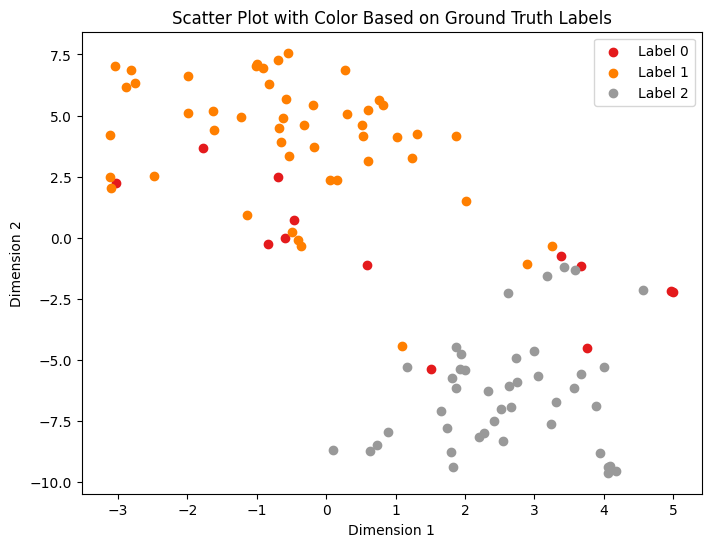

<ipython-input-29-2b934e4faf28>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('Set1', len(labels))
<ipython-input-29-2b934e4faf28>:52: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[mask], y[mask], c=colormap(label), label=f'Label {label}')


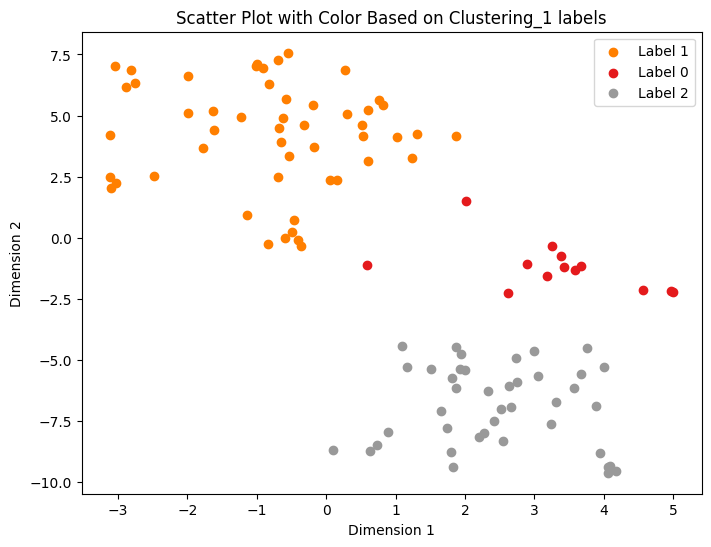

In [ ]:
# Creating an array with the embedding values
visual_array_1 = df_embed_1.values

# Fitting our method to this array
tsne = TSNE(n_components=2)
embedded_data_1 = tsne.fit_transform(visual_array_1)

# Creating a new dataframe that have the ground truth labels and labels found from k means for this Node2Vec
visual_df_1 = pd.DataFrame(embedded_data_1, columns=['Dimension 1', 'Dimension 2'])
visual_df_1['ground_truth_labels'] = df['ground_truth_labels']
visual_df_1['Clustering_1'] = df['Clustering_1']

# Plotting using ground truth labels

# Get the values for the x and y coordinates
x = visual_df_1['Dimension 1']
y = visual_df_1['Dimension 2']

# Get the unique labels from ground_truth_labels
labels = visual_df_1['ground_truth_labels'].unique()

# Define a colormap for the labels
colormap = plt.cm.get_cmap('Set1', len(labels))

# Create a scatter plot and assign colors based on labels
plt.figure(figsize=(8, 6))
for label in labels:
    mask = visual_df_1['ground_truth_labels'] == label
    plt.scatter(x[mask], y[mask], c=colormap(label), label=f'Label {label}')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter Plot with Color Based on Ground Truth Labels')
plt.legend()
plt.show()

# Plotting using labels produced from k-means 
# Get the values for the x and y coordinates
x = visual_df_1['Dimension 1']
y = visual_df_1['Dimension 2']

# Get the unique labels from ground_truth_labels 
labels = visual_df_1['Clustering_1'].unique()

# Define a colormap for the labels
colormap = plt.cm.get_cmap('Set1', len(labels))

# Create a scatter plot and assign colors based on labels
plt.figure(figsize=(8, 6))
for label in labels:
    mask = visual_df_1['Clustering_1'] == label
    plt.scatter(x[mask], y[mask], c=colormap(label), label=f'Label {label}')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter Plot with Color Based on Clustering_1 labels')
plt.legend()
plt.show()

<ipython-input-30-2a5e889c84d5>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('Set1', len(labels))
<ipython-input-30-2a5e889c84d5>:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[mask], y[mask], c=colormap(label), label=f'Label {label}')


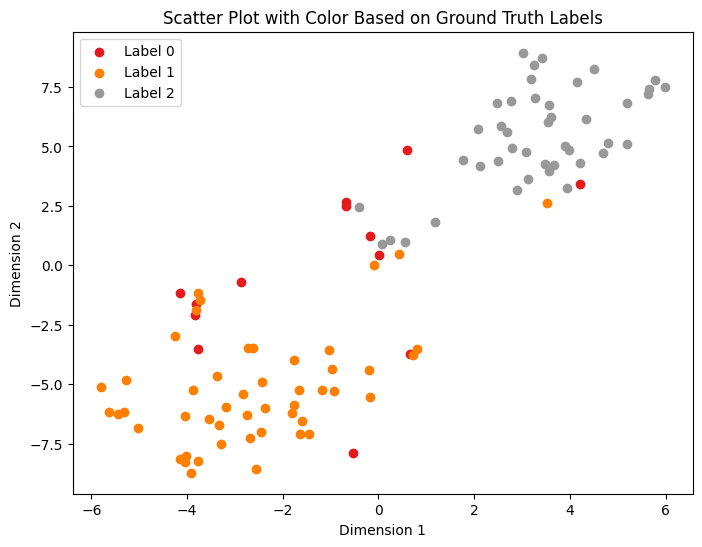

<ipython-input-30-2a5e889c84d5>:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('Set1', len(labels))
<ipython-input-30-2a5e889c84d5>:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[mask], y[mask], c=colormap(label), label=f'Label {label}')


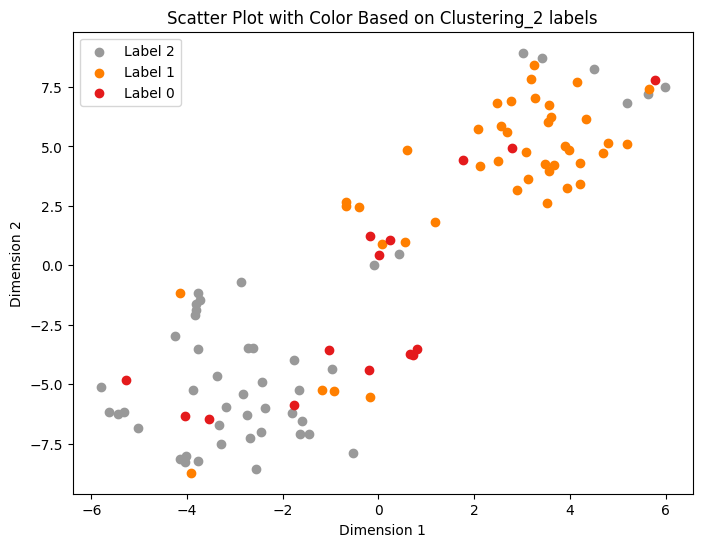

In [ ]:
# Creating an array with the embedding values
visual_array_2 = df_embed_2.values

# Fitting our method to this array
tsne = TSNE(n_components=2)
embedded_data_2 = tsne.fit_transform(visual_array_2)

# Creating a new dataframe that have the ground truth labels and labels found from k means for this Node2Vec
visual_df_2 = pd.DataFrame(embedded_data_2, columns=['Dimension 1', 'Dimension 2'])
visual_df_2['ground_truth_labels'] = df['ground_truth_labels']
visual_df_2['Clustering_2'] = df['Clustering_2']

# Plotting using ground truth labels

# Get the values for the x and y coordinates
x = visual_df_2['Dimension 1']
y = visual_df_2['Dimension 2']

# Get the unique labels from ground_truth_labels column
labels = visual_df_2['ground_truth_labels'].unique()

# Define a colormap for the labels
colormap = plt.cm.get_cmap('Set1', len(labels))

# Create a scatter plot and assign colors based on labels
plt.figure(figsize=(8, 6))
for label in labels:
    mask = visual_df_1['ground_truth_labels'] == label
    plt.scatter(x[mask], y[mask], c=colormap(label), label=f'Label {label}')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter Plot with Color Based on Ground Truth Labels')
plt.legend()
plt.show()

# Plotting using labels produced from k-means 

# Get the unique labels from ground_truth_labels 
labels = visual_df_2['Clustering_2'].unique()

# Define a colormap for the labels
colormap = plt.cm.get_cmap('Set1', len(labels))

# Create a scatter plot and assign colors based on labels
plt.figure(figsize=(8, 6))
for label in labels:
    mask = visual_df_2['Clustering_2'] == label
    plt.scatter(x[mask], y[mask], c=colormap(label), label=f'Label {label}')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter Plot with Color Based on Clustering_2 labels')
plt.legend()
plt.show()

<ipython-input-31-7c8540688352>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('Set1', len(labels))
<ipython-input-31-7c8540688352>:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[mask], y[mask], c=colormap(label), label=f'Label {label}')


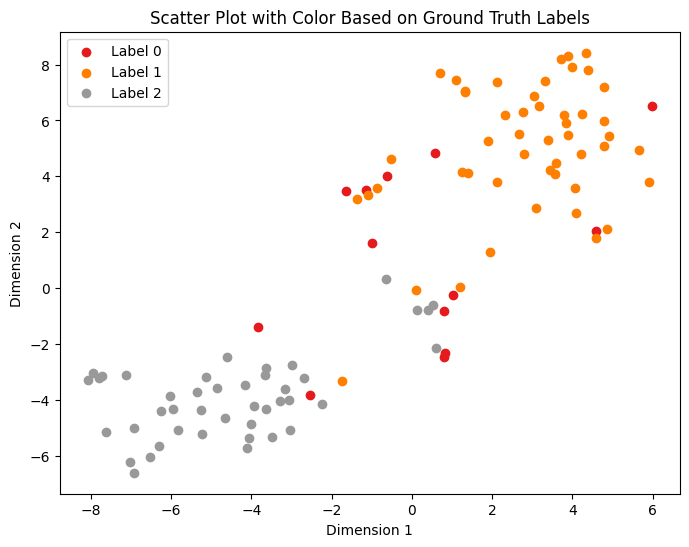

<ipython-input-31-7c8540688352>:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('Set1', len(labels))
<ipython-input-31-7c8540688352>:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[mask], y[mask], c=colormap(label), label=f'Label {label}')


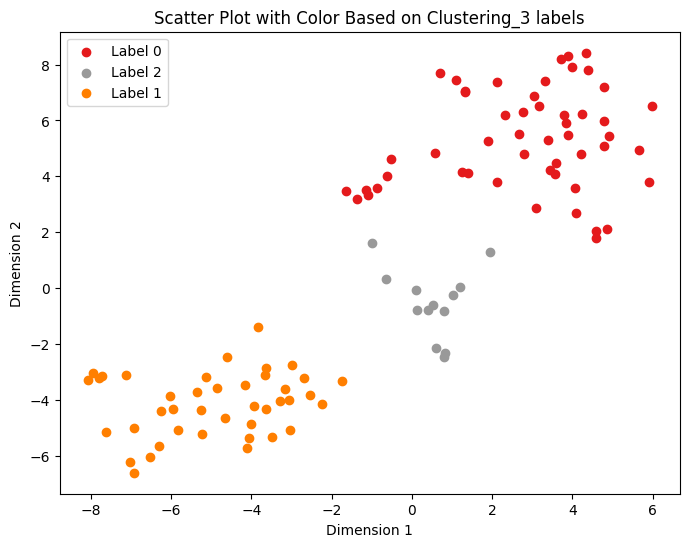

In [ ]:
# Creating an array with the embedding values
visual_array_3 = df_embed_3.values

# Fitting our method to this array
tsne = TSNE(n_components=2)
embedded_data_3 = tsne.fit_transform(visual_array_3)

# Creating a new dataframe that have the ground truth labels and labels found from k means for this Node2Vec
visual_df_3 = pd.DataFrame(embedded_data_3, columns=['Dimension 1', 'Dimension 2'])
visual_df_3['ground_truth_labels'] = df['ground_truth_labels']
visual_df_3['Clustering_3'] = df['Clustering_3']


# Plotting using ground truth labels
# Get the values for the x and y coordinates
x = visual_df_3['Dimension 1']
y = visual_df_3['Dimension 2']

# Get the unique labels from ground_truth_labels
labels = visual_df_3['ground_truth_labels'].unique()

# Define a colormap for the labels
colormap = plt.cm.get_cmap('Set1', len(labels))

# Create a scatter plot and assign colors based on labels
plt.figure(figsize=(8, 6))
for label in labels:
    mask = visual_df_3['ground_truth_labels'] == label
    plt.scatter(x[mask], y[mask], c=colormap(label), label=f'Label {label}')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter Plot with Color Based on Ground Truth Labels')
plt.legend()
plt.show()

# Plotting using labels produced from k-means 
# Get the unique labels from ground_truth_labels column
labels = visual_df_3['Clustering_3'].unique()

# Define a colormap for the labels
colormap = plt.cm.get_cmap('Set1', len(labels))

# Create a scatter plot and assign colors based on labels
plt.figure(figsize=(8, 6))
for label in labels:
    mask = visual_df_3['Clustering_3'] == label
    plt.scatter(x[mask], y[mask], c=colormap(label), label=f'Label {label}')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter Plot with Color Based on Clustering_3 labels')
plt.legend()
plt.show()

Και στις τρεις περιπτώσεις αναπαράστασης των node embeddings στον χώρο, βλέπουμε ότι ο k means βρισκόταν σε πολύ καλή θέση να ξεχωρίσει τα nodes με τα ίδια labels. Προφανώς και υπάρχουν ορισμένοι κόμβοι τους οποίους δεν μπόρεσε να κατηγοριοποιήσει στο σωστό community, καθώς λαμβάνει υπόψη την απόσταση μεταξύ των κόμβων